# Imports

In [8]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import resnet50

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from IPython.display import display

from transformers import BertTokenizer, BertModel



# Set up dataloader and visualize data


This is the dataset given to us for the class compition. Within the Train_data, the format is as folows: (csv)

- Image: name of image in teh train_images directory
- superclass_index: index of a parent class (i.e. dog) that is mappend in superclass_mapping
- Isubclass_index: index of child class (i.e. german shepard) that is mapped in subclass_mapping
- description: a desctiption of the image in the following format
    - "nature photograph of a dog, specifically a Maltese dog, Maltese terrier, Maltese, centered composition, photorealistic, 8k, the animal is fully visible within frame and not cut off"


## Create Pytorch Dataset

In [17]:

class MultiClassImageDataset(Dataset):
    """
    This creates a dataset (not dataloader) for the data given and the contrastive learning task.
    """

    def __init__(self, ann_df, img_dir, transform=None): 
        """
        Create the dataset

        Args:
            ann_df (Dataframe): Data that is read the train_data.csv (see format above)
            img_dir (str): Directiory of train images
            transform (torch.transformations): list of transformations to be appled on each image (i.e. cropping, noise etc.) (not contraint to transformations
            meant for noise i.e. resize, convert to tensor, ...)
        """
        self.ann_df = ann_df 
        self.img_dir = img_dir
        self.transform = transform
        # create the tokenizer for the text_encoder
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        """
        returns the length of the dataset (number of training examples). Needed for Pytorch
        """
        return len(self.ann_df)

    def __getitem__(self, idx):
        """
        Gets an training example from the dataset. (with approiate transformations and tokenizations)

        Args:
            idx (int): index of training example to retrieve
        """
        # get the correct image from the train_images directory and read it in a usable format
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        # For contrastive learning, we are interested in the string explaining the image (description)
        description = self.ann_df['description'][idx]
        # Apply all transformations (cropping, masking, resize, ...) to the image
        if self.transform:
            image = self.transform(image)
        # Tokenize the description so that it can be used by the text_encoder (keep in mind attenton_mask is needed for encoder). 
        # set max length, truncate if over and return pytorch-tensors for each tokenization
        tokenized = self.tokenizer(description, padding='max_length', truncation=True, 
                                  max_length=100, return_tensors='pt')
        
        return image, tokenized['input_ids'].squeeze(), tokenized['attention_mask'].squeeze()


## Visualze dataset

### Load data into Pandas Dataframe

In [18]:
train_df = pd.read_csv('train_data.csv')
test_ann_df = pd.read_csv('test_data.csv')


train_img_dir = 'train_images'
test_img_dir = 'test_images'

### Examine image and description in train_images

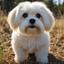

nature photograph of a dog, specifically a Maltese dog, Maltese terrier, Maltese, centered composition, photorealistic, 8k, the animal is fully visible within frame and not cut off


In [19]:
img_name = train_df['image'][0]
img_path = os.path.join("./train_images", img_name)
image = Image.open(img_path).convert('RGB')
display(image)
description = train_df['description'][0]
print(description)

### Examine transformations on a image

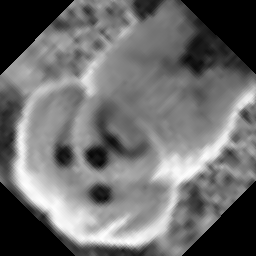

tensor([[[-0.5596, -0.5596, -0.6109,  ...,  0.6734,  0.5193,  0.5193],
         [-0.5596, -0.5596, -0.6109,  ...,  0.6734,  0.5193,  0.5193],
         [-0.6281, -0.6281, -0.6794,  ...,  0.6392,  0.4851,  0.4851],
         ...,
         [-0.5767, -0.5767, -0.5596,  ..., -1.4500, -1.4843, -1.4843],
         [-0.6281, -0.6281, -0.6109,  ..., -1.4843, -1.5185, -1.5185],
         [-0.6281, -0.6281, -0.6109,  ..., -1.4843, -1.5185, -1.5185]],

        [[-0.4776, -0.4776, -0.5301,  ...,  0.9405,  0.7829,  0.7829],
         [-0.4776, -0.4776, -0.5301,  ...,  0.9405,  0.7829,  0.7829],
         [-0.5476, -0.5476, -0.6001,  ...,  0.9055,  0.7479,  0.7479],
         ...,
         [-0.8627, -0.8627, -0.8452,  ..., -1.3880, -1.4230, -1.4230],
         [-0.9153, -0.9153, -0.8978,  ..., -1.4055, -1.4405, -1.4405],
         [-0.9153, -0.9153, -0.8978,  ..., -1.4055, -1.4405, -1.4405]],

        [[-0.4624, -0.4624, -0.5147,  ...,  1.4722,  1.3154,  1.3154],
         [-0.4624, -0.4624, -0.5147,  ...,  1

In [20]:
image_preprocessing = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(),
    transforms.RandomRotation(180)
])

display(image_preprocessing(image))

image_preprocessing = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # this mean and std are one of the industry standards
])

transformed_image = image_preprocessing(image)
display(transformed_image)


### Examine tokenization and attention mask

In [21]:
description = train_df['description'][0]
print(description)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized = tokenizer(description, padding='max_length', truncation=True, 
                                  max_length=100, return_tensors='pt')
print(tokenized['input_ids'].squeeze())
print(tokenized['attention_mask'].squeeze())

nature photograph of a dog, specifically a Maltese dog, Maltese terrier, Maltese, centered composition, photorealistic, 8k, the animal is fully visible within frame and not cut off
tensor([  101,  3267,  9982,  1997,  1037,  3899,  1010,  4919,  1037, 18563,
         3899,  1010, 18563, 26568,  2121,  1010, 18563,  1010,  8857,  5512,
         1010,  6302, 22852,  6553,  1010,  1022,  2243,  1010,  1996,  4111,
         2003,  3929,  5710,  2306,  4853,  1998,  2025,  3013,  2125,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Create and Examine Dataset

In [22]:
image_preprocessing = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train and val split
train_dataset = MultiClassImageDataset(train_df, train_img_dir, transform=image_preprocessing)

image, token, mask = train_dataset[0]
print(image)
print(token)
print(mask)

tensor([[[-0.5596, -0.5596, -0.6109,  ...,  0.6734,  0.5193,  0.5193],
         [-0.5596, -0.5596, -0.6109,  ...,  0.6734,  0.5193,  0.5193],
         [-0.6281, -0.6281, -0.6794,  ...,  0.6392,  0.4851,  0.4851],
         ...,
         [-0.5767, -0.5767, -0.5596,  ..., -1.4500, -1.4843, -1.4843],
         [-0.6281, -0.6281, -0.6109,  ..., -1.4843, -1.5185, -1.5185],
         [-0.6281, -0.6281, -0.6109,  ..., -1.4843, -1.5185, -1.5185]],

        [[-0.4776, -0.4776, -0.5301,  ...,  0.9405,  0.7829,  0.7829],
         [-0.4776, -0.4776, -0.5301,  ...,  0.9405,  0.7829,  0.7829],
         [-0.5476, -0.5476, -0.6001,  ...,  0.9055,  0.7479,  0.7479],
         ...,
         [-0.8627, -0.8627, -0.8452,  ..., -1.3880, -1.4230, -1.4230],
         [-0.9153, -0.9153, -0.8978,  ..., -1.4055, -1.4405, -1.4405],
         [-0.9153, -0.9153, -0.8978,  ..., -1.4055, -1.4405, -1.4405]],

        [[-0.4624, -0.4624, -0.5147,  ...,  1.4722,  1.3154,  1.3154],
         [-0.4624, -0.4624, -0.5147,  ...,  1

### Create Dataloader from dataset

In [23]:
# Create dataloader (A torch class that makes it much easier to apply dataset level transformations (shuffling, batches))
batch_size = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

# Set up model(s) for contrastive learning

In this setup I will largely mimic CLIP. For this I will leverage the pre-trained models BERT and ResNet50 (although you could train from scratch). This will be one class which will encapsilate all forward passes for contrastive learning. Specifically:

- Pretrained Models:
    - BERT: A Encoder transformer, that will be used to get good embeddings for the descriptions (extract (CLS) token, also refered to as pooler_output)
    - ResNet50: A CNN for originally created for 1000 dimesional classification, will replace final layer in network to match embedding size of BERT
    - These model weights will be frozen during training and a projection matrix (or layers) will be trained to get the latent embeddings
- Projection Matrices:
    - Text projection: It will be one feed forward layer appended to the end of BERT
    - Image projections: It will be one feed forward layer replacing the last layer in ResNet50
    - These projection matrices will not have a non-linear activation functions (making them linear projections w.r.t. the outputs of connected model)

In [34]:
class ConstrastiveModel(nn.Module):
    """
    One class that will hold all NN models and layers including BERT, ResNet50, Image projection and text projection
    """

    def __init__(self):
        """
        Creates the torch Module and will initilize all models and projections needed.
        """
        super(ConstrastiveModel, self).__init__()
        # Load pre-trained BERT for text encoding
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        # Load pre-trained ResNet for image encoding
        self.image_encoder = resnet50(pretrained=True)
        # Replace final fc layer to match embedding dimension with text encoder
        # I found that this is important to do bc ResNet50 is trained for classification. We don't want this output. Replacing the last layer might help it "forget" this
        embedding_dim = self.text_encoder.config.hidden_size # I found that they have this online
        self.image_encoder.fc = nn.Linear(self.image_encoder.fc.in_features, embedding_dim) # as for this - checkout the _init_ method in https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L284

        # Projection layers to align embeddings
        self.text_projection = nn.Linear(embedding_dim, embedding_dim)
        self.image_projection = nn.Linear(embedding_dim, embedding_dim)

    def encode_descriptions(self, tokens, attention_mask):
        # get the embedding of the description from BERT
        output = self.text_encoder(input_ids=tokens, 
                                   attention_mask=attention_mask,
                                   return_dict=True)
        # Use [CLS] token embedding as text representation
        text_features = output.last_hidden_state[:, 0, :]
        # now apply the projection layer to the embedding
        text_features = self.text_projection(text_features)

        return text_features

    def encode_image(self, image):
        # Get image embedding after applying resnet
        image = self.image_encoder(image)
        # Now apply projection  layer to the embedding
        image = self.image_projection(image)

        return image

    def forward(self, image, tokens, attention_mask):
        # get latent space encodings for image and description
        text_encoding = self.encode_descriptions(tokens, attention_mask)
        image_encoding = self.encode_image(image)
        
        return image_encoding, text_encoding


## Examine new embedding models (BERT, ResNet50)

### Examine BERT

In [ ]:
constrastivemodel = ConstrastiveModel()

image, tokens, att_mask = train_dataset[0]
# add batch dimesnsion
tokens = tokens.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)
print(tokens.shape)
bert_output = constrastivemodel.text_encoder(tokens, att_mask).last_hidden_state[0,0,:]
print(bert_output.shape)
print(bert_output[:5])

projection_output = constrastivemodel.text_projection(bert_output)
print(projection_output.shape)
print(projection_output[:5])

/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 100])
torch.Size([768])
tensor([-0.7247, -0.1824, -0.2228, -0.2153,  0.0441], grad_fn=<SliceBackward0>)
torch.Size([768])
tensor([-0.0326,  0.1654, -0.0862,  0.4329,  0.2358], grad_fn=<SliceBackward0>)


### Examine ResNet50

In [ ]:
print(image.shape)
image_batch = image.unsqueeze(0)
original_encoding = resnet50(pretrained=True)(image_batch)[0]
print(f"original: {original_encoding.shape}")
image_encoding = constrastivemodel.image_encoder(image_batch)[0,:]
print(image_encoding.shape)
print(image_encoding[:5])
image_encoding  = constrastivemodel.image_projection(image_encoding)
print(image_encoding.shape)
print(image_encoding[:5])

torch.Size([3, 256, 256])
original: torch.Size([1000])
torch.Size([768])
tensor([-0.2769, -0.2224, -0.0710, -0.3389,  0.0983], grad_fn=<SliceBackward0>)
torch.Size([768])
tensor([-0.2101, -0.1238,  0.1176,  0.0182, -0.1285], grad_fn=<SliceBackward0>)


# Creating contrastive Loss function

Based on the SimClr paper, the constrastive loss is:

- $l_{i,j} = \frac{exp({cosSim(z_i,z_j)/\tau})}{\sum_{k=1}^{2N}\mathbb{1}_{k \neq j} exp(cosSim(z_i,z_k)/ \tau)}$

This part of the code will implement the constrastive loss. I will follow the code in the CLIP paper, look at paper to see the code I am mirroring

In [25]:
class ContrastiveLoss(nn.Module):
    """
    This class will implement the contrastive loss presented in SimClr and follow the implementation in CLIP
    It is important to have this implemented as a module so that we can set an optimizer and compute backprop
    """

    def __init__(self, temp=0.01, device="cuda"):
        """
        Initialize the loss, uses cross-entropy and needs a tempature to be set.
        """
        super(ContrastiveLoss, self).__init__()
        self.temp = temp
        self.cross_entropy = nn.CrossEntropyLoss()
        self.device = device

    def forward(self, image_encoding, text_encoding):
        """
        implements the contrastive loss function
        """
        # important to determine positive pairs within the batch
        batch_size = image_encoding.shape[0]

        # Ensure features are normalized for proper cosine similarity (uses L2 norm) (set dim 1 to avoid batch)
        image_encoding = F.normalize(image_encoding, p=2, dim=1)
        text_encoding = F.normalize(text_encoding, p=2, dim=1)

        # Calculate cosine similarity between all image-text pairs (since each are normalized, just dot product)
        # Since vectors are normalized, dot product equals cosine similarity
        logits = torch.matmul(image_encoding, text_encoding.T) / self.temp

        # Labels for both directions (image->text and text->image)
        # We want the diagonal elements to match (each image with its corresponding text)
        labels = torch.arange(batch_size, device=self.device)

        # Calculate loss in both directions and average
        image_to_text_loss = self.cross_entropy(logits, labels)
        text_to_image_loss = self.cross_entropy(logits.T, labels)

        # Total loss is the average of both directions
        total_loss = (image_to_text_loss + text_to_image_loss) / 2.0

        return total_loss

    

## Examine Contrastive loss

In [ ]:
device = "cpu"
try:
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.mps.is_available():
        device = "mps"
except:
    device = "cpu"


loss = ContrastiveLoss(device=device)


# Anchor embeddings (e.g., original samples)
embedding_one = torch.tensor(np.array([
    [2, 3],    # Sample 1
    [5, 6],    # Sample 2
    [9, 8]     # Sample 3
]), dtype=torch.float32).to(device)

# Large difference (should have high loss) — represents **negatives**
embedding_large_diff = torch.tensor(np.array([
    [9, 8],    # Far from [2,3]
    [15, 16],  # Far from [5,6]
    [2, 3]     # Far from [9,8]
]), dtype=torch.float32).to(device)

# Small difference (still a bit off) — represents **imperfect positives**
embedding_small_diff_all = torch.tensor(np.array([
    [5, 6],     # Close to [2,3]
    [2, 3],     # Close to [5,6]
    [11, 12]    # Close to [9,8]
]), dtype=torch.float32).to(device)

# Small difference and semantically meaningful (best case positives)
embedding_small_diff_positive = torch.tensor(np.array([
    [3, 4],     # Very close to [2,3]
    [5, 6],     # Exactly matches
    [8, 9]      # Very close to [9,8]
]), dtype=torch.float32).to(device)

print("Embedding Shape:", embedding_one.shape)

# Loss comparisons
print("Loss with large difference embeddings (should be high):")
print(loss(embedding_one, embedding_large_diff))

print("Loss with small diff (but noisy) embeddings (medium):")
print(loss(embedding_one, embedding_small_diff_all))

print("Loss with small diff and aligned positives (should be lowest):")
print(loss(embedding_one, embedding_small_diff_positive))

# One thing to try is to play with the tempature, I noticed the larger the temapture the more difference in these (better signal)
# So larger tempature probably means faster convergence (to a point)

Embedding Shape: torch.Size([3, 2])
Loss with large difference embeddings (should be high):
tensor(2.6807, device='mps:0')
Loss with small diff (but noisy) embeddings (medium):
tensor(1.0838, device='mps:0')
Loss with small diff and aligned positives (should be lowest):
tensor(0.8588, device='mps:0')


# Training the model

Using all that has been implemented beforehand, create a training function for the models using contrastive learning

In [ ]:
def train(model, train_loader, optimizer, epochs=5, device="mps"):
    model.to(device)
    contrasitve_loss = ContrastiveLoss(device=device)
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, tokens, att_mask) in enumerate(train_loader):
            # move data to correct device
            images = images.to(device)
            tokens = tokens.to(device)
            att_mask = att_mask.to(device)

            # clear optimizer gradients
            optimizer.zero_grad()

            # compute forward pass
            image_embedding, text_embedding = model(images, tokens, att_mask)

            # compute loss
            loss = contrasitve_loss(image_embedding, text_embedding)

            # compute gradient and update weights
            loss.backward()
            optimizer.step()
            # add to loss
            total_loss += loss.item()

            if (batch_idx+1) % 25 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
    
    return model

## Training the model

In [ ]:

# Initialize model
model = ConstrastiveModel()

# Setup optimizer
# Only train the projection layers and the ResNet fc layer, keep pre-trained weights frozen
params_to_train = list(model.text_projection.parameters()) + \
                    list(model.image_projection.parameters()) + \
                    list(model.image_encoder.fc.parameters())

optimizer = optim.AdamW(params_to_train, lr=5e-5)


# Train model
model = train(model, train_loader, optimizer)



Epoch 1/5, Batch 0/99, Loss: 5.3535
Epoch 1/5, Batch 25/99, Loss: 3.4983
Epoch 1/5, Batch 50/99, Loss: 2.7497
Epoch 1/5, Batch 75/99, Loss: 2.3169
Epoch 1/5, Average Loss: 2.9531
Epoch 2/5, Batch 0/99, Loss: 1.8774
Epoch 2/5, Batch 25/99, Loss: 1.2132
Epoch 2/5, Batch 50/99, Loss: 1.4958
Epoch 2/5, Batch 75/99, Loss: 1.3100
Epoch 2/5, Average Loss: 1.4716
Epoch 3/5, Batch 0/99, Loss: 0.9326
Epoch 3/5, Batch 25/99, Loss: 0.9663
Epoch 3/5, Batch 50/99, Loss: 1.1032
Epoch 3/5, Batch 75/99, Loss: 1.0909
Epoch 3/5, Average Loss: 1.0587
Epoch 4/5, Batch 0/99, Loss: 1.1936
Epoch 4/5, Batch 25/99, Loss: 0.9335
Epoch 4/5, Batch 50/99, Loss: 0.8251
Epoch 4/5, Batch 75/99, Loss: 0.9209
Epoch 4/5, Average Loss: 0.9316
Epoch 5/5, Batch 0/99, Loss: 0.9327
Epoch 5/5, Batch 25/99, Loss: 0.9538
Epoch 5/5, Batch 50/99, Loss: 0.8010
Epoch 5/5, Batch 75/99, Loss: 0.9605
Epoch 5/5, Average Loss: 0.8684


In [70]:
# needed to run four times total to see good results
model = train(model, train_loader, optimizer)

Epoch 1/5, Batch 0/99, Loss: 0.6650
Epoch 1/5, Batch 25/99, Loss: 0.6222
Epoch 1/5, Batch 50/99, Loss: 0.6790
Epoch 1/5, Batch 75/99, Loss: 0.6613
Epoch 1/5, Average Loss: 0.6629
Epoch 2/5, Batch 0/99, Loss: 0.5310
Epoch 2/5, Batch 25/99, Loss: 0.5350
Epoch 2/5, Batch 50/99, Loss: 0.6638
Epoch 2/5, Batch 75/99, Loss: 0.6737
Epoch 2/5, Average Loss: 0.6646
Epoch 3/5, Batch 0/99, Loss: 0.6811
Epoch 3/5, Batch 25/99, Loss: 0.7040
Epoch 3/5, Batch 50/99, Loss: 0.4731
Epoch 3/5, Batch 75/99, Loss: 0.6018
Epoch 3/5, Average Loss: 0.6292
Epoch 4/5, Batch 0/99, Loss: 0.6711
Epoch 4/5, Batch 25/99, Loss: 0.6219
Epoch 4/5, Batch 50/99, Loss: 0.5560
Epoch 4/5, Batch 75/99, Loss: 0.7029
Epoch 4/5, Average Loss: 0.6339
Epoch 5/5, Batch 0/99, Loss: 0.5868
Epoch 5/5, Batch 25/99, Loss: 0.7599
Epoch 5/5, Batch 50/99, Loss: 0.7516
Epoch 5/5, Batch 75/99, Loss: 0.6210
Epoch 5/5, Average Loss: 0.6399


In [71]:
# Save trained model
torch.save(model.state_dict(), "models/clip_model.pth")

# How to use this for downstream tasks: classification

The idea here is that for a given image, you get the models embedding. Then you can try several possible text prompts available from the training data to pass into the text encoder. For each image embedding, text embedding pair take the cosine simularity between them and the one with the highest value is the answer. For example:

- cosineSim(embedded_img_french_bulldog, embedded_description_german_shepard) = 0.6
- cosineSim(embedded_img_french_bulldog, embedded_description_cat) = 0.2
- cosineSim(embedded_img_french_bulldog, embedded_description_french_bulldog) = 0.9

The label would then be french_bulldog

In [74]:
image, _, _ = train_dataset[3]
description_correct =  "nature photograph of a dog, specifically a Shih-Tzu, centered composition, photorealistic, 8k, the animal is fully visible within frame and not cut off"
description_correct_tokenize = tokenizer(description_correct, padding='max_length', truncation=True, 
                                  max_length=100, return_tensors='pt')

description_another_dog = "nature photograph of a dog, specifically a Afghan hound, Afghan, centered composition, photorealistic, 8k, the animal is fully visible within frame and not cut off"
description_another_dog_tokenize = tokenizer(description_another_dog, padding='max_length', truncation=True, 
                                  max_length=100, return_tensors='pt')

description_bird = "nature photograph of a bird, specifically a oystercatcher, oyster catcher, centered composition, photorealistic, 8k, the animal is fully visible within frame and not cut off"
description_bird_tokenize = tokenizer(description_bird, padding='max_length', truncation=True, 
                                  max_length=100, return_tensors='pt')


image_embedding = model.encode_image(image.unsqueeze(0).to("mps"))[0,:]

image_embedding = F.normalize(image_embedding, p=2, dim=0)

description_correct_embedding = model.encode_descriptions(
    description_correct_tokenize['input_ids'].to("mps"),
    description_correct_tokenize['attention_mask'].to("mps"),
    )[0,:]

description_correct_embedding = F.normalize(description_correct_embedding, p=2, dim=0)

description_another_dog_embedding = model.encode_descriptions(
    description_another_dog_tokenize['input_ids'].to("mps"),
    description_another_dog_tokenize['attention_mask'].to("mps"),
    )[0,:]

description_another_dog_embedding = F.normalize(description_another_dog_embedding, p=2, dim=0)

description_bird_embedding = model.encode_descriptions(
    description_bird_tokenize['input_ids'].to("mps"),
    description_bird_tokenize['attention_mask'].to("mps"),
    )[0,:]

description_bird_embedding = F.normalize(description_bird_embedding, p=2, dim=0)

correct_value = torch.dot(image_embedding, description_correct_embedding)
another_dog_value = torch.dot(image_embedding, description_another_dog_embedding)
bird_value = torch.dot(image_embedding, description_bird_embedding)

print(f"The value for the correct description: {correct_value}\nThe value for a description of another dog breed: {another_dog_value}\nThe value for a description of a bird: {bird_value}")
 



The value for the correct description: 0.21726536750793457
The value for a description of another dog breed: 0.20572520792484283
The value for a description of a bird: 0.18783292174339294
